<a href="https://colab.research.google.com/github/fabriciocovalesci/tcc_predict_crypto/blob/main/model_predict/predict_crypto/ethereum/Ethereum_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modelo preditivo Ethereum

- Instalar biblioteca **yfinance**

In [1]:
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 19.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


- Importar bibliotecas de manipulação de dados

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

- Importar bibliotecas realizar as predições

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

- Importar bibliotecas para plotar gráficos

In [4]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('ggplot')
%matplotlib inline

- Importar bibliotecas internas do python

In [5]:
from functools import reduce
from datetime import datetime

- Definir datas para capturar os dados

In [6]:
date_today = datetime.strftime(datetime.today(), '%Y-%m-%d')
date_init = "2014-01-01"

- Criar funções auxiliares 

In [7]:
TICKER = "ETH-USD"

def download_tickers(ticker):
  try:
    asset = yf.download(ticker, start=date_init, end=date_today, interval='1d')
    return asset.Close
  except Exception as err:
    print(f"ERROR: {err}")

  
def create_data_frame(asset_close, ticker):
  return pd.DataFrame(asset_close).rename(columns = {'Close': ticker})


def mean_absolute_percentage_error(y_true, y_pred):
	"""Take in true and predicted values and calculate the MAPE score"""
	y_true, y_pred = np.array(y_true), np.array(y_pred)
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- Download dos dados

In [8]:
df_eth = yf.download(TICKER, date_init, date_today)
df_eth = df_eth.reset_index()

[*********************100%***********************]  1 of 1 completed


- Renomear colunas

In [9]:
df_eth.rename({'Date': 'timestamp', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Adj Close': 'close', 'Volume': 'volume' }, axis=1, inplace=True)

In [10]:
df_eth.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
Close               float64
close               float64
volume                int64
dtype: object

- Converter data

In [11]:
df_eth['timestamp'] = pd.to_datetime(df_eth['timestamp'], format="%Y-%m-%d")

- Criar médias móveis de 7 dias e 21 dias

In [12]:
df_eth['mm7d'] = df_eth['close'].rolling(7).mean()
df_eth['mm21d'] = df_eth['close'].rolling(21).mean()

df_eth.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1813,2022-10-27,1566.841431,1574.403442,1510.816772,1514.374878,1514.374878,22813499245,1409.328299,1337.121890
1814,2022-10-28,1514.323120,1568.633911,1493.871094,1555.477905,1555.477905,19974623205,1445.832799,1347.739078
1815,2022-10-29,1555.274658,1652.382202,1549.983643,1619.698486,1619.698486,21618154775,1489.461269,1362.224697
1816,2022-10-30,1619.697876,1637.037842,1579.485229,1590.783325,1590.783325,13930073427,1521.937884,1374.995129
1817,2022-10-31,1590.481323,1630.452881,1555.918945,1572.714478,1572.714478,19306919714,1554.468733,1388.394026


- Função de agrupamento dos dados

In [13]:
def group_data(type_group):
  new_df = df_eth.groupby(pd.Grouper(key="timestamp", freq=type_group)).sum()
  new_df.reset_index(inplace=True)
  return new_df

- Função para plotar grafico conforme o Agrupamento dos Dados
- Tipo de agrupamento:
- Por Meses (M) ou por Semanas (W)
- Por Ano (year)
- Tipo de grafico: 'bar',  'line',  'hist',  'barh'

In [14]:
def create_plot_custom(filter_Mounth_or_Week, year, type_plot):
  """ 
    Cria um grafico filtrando por Ano, Meses ou Semanas

    filter_Mounth_or_Week: 'M' ou 'W'
    type_plot: 'line', 'bar', 'hist', 'barh'
  
  """
  if year >= 2014 and year <= 2022 and filter_Mounth_or_Week in ("M", "W"):
    filtro_label = None
    df_filter = group_data(filter_Mounth_or_Week)
    include = df_filter[df_filter['timestamp'].dt.year == year]
    meses = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
    if len(include.index) == 12:
      include.index = meses[:len(include.index)]
      filtro_label = "Meses"
    elif len(include.index) > 50:
      include.index = [i for i in range(0, len(include.index))]
      filtro_label = "Semanas"
    include.plot(y="close", kind=type_plot, figsize=(14, 8),rot=30, title=f'Distruibuição por {filtro_label} - ano {year}', ylabel='Preço US$', xlabel=filtro_label, color="blue")

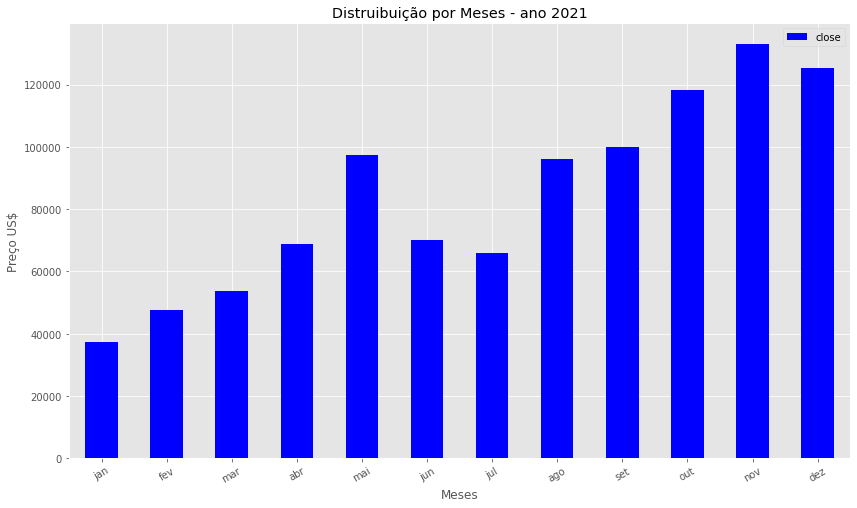

In [15]:
create_plot_custom("M", 2021, "bar")

- Empurrando para frente os valores da criptomoeda

In [16]:
df_eth['close'] = df_eth['close'].shift(-1)
df_eth.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1813,2022-10-27,1566.841431,1574.403442,1510.816772,1514.374878,1555.477905,22813499245,1409.328299,1337.121890
1814,2022-10-28,1514.323120,1568.633911,1493.871094,1555.477905,1619.698486,19974623205,1445.832799,1347.739078
1815,2022-10-29,1555.274658,1652.382202,1549.983643,1619.698486,1590.783325,21618154775,1489.461269,1362.224697
1816,2022-10-30,1619.697876,1637.037842,1579.485229,1590.783325,1572.714478,13930073427,1521.937884,1374.995129
1817,2022-10-31,1590.481323,1630.452881,1555.918945,1572.714478,NaN,19306919714,1554.468733,1388.394026


- Remover os dados nulos

In [17]:
df_eth.dropna(inplace=True)
df_eth

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
20,2017-11-29,473.281006,522.307007,425.071014,427.523010,447.114014,2675940096,457.637573,376.523430
21,2017-11-30,431.214996,465.497009,401.243011,447.114014,466.540009,1903040000,462.915863,382.534383
22,2017-12-01,445.209015,472.609009,428.312012,466.540009,463.449005,1247879936,461.720006,390.500432
23,2017-12-02,466.851013,476.239014,456.653015,463.449005,465.852997,943649984,461.316149,397.584622
24,2017-12-03,463.704987,482.813995,451.851990,465.852997,470.204010,990556992,460.533722,405.105813
...,...,...,...,...,...,...,...,...,...
1812,2022-10-26,1461.133179,1584.636719,1460.428711,1566.566650,1514.374878,32705548427,1376.303449,1329.375918
1813,2022-10-27,1566.841431,1574.403442,1510.816772,1514.374878,1555.477905,22813499245,1409.328299,1337.121890
1814,2022-10-28,1514.323120,1568.633911,1493.871094,1555.477905,1619.698486,19974623205,1445.832799,1347.739078
1815,2022-10-29,1555.274658,1652.382202,1549.983643,1619.698486,1590.783325,21618154775,1489.461269,1362.224697


- Testar se o DataFrame possui dados nulos

In [18]:
assert df_eth.isnull().sum().sum() == 0

- Separar os dados em Treino, Teste e Validação. 

In [19]:
qtd_linhas = len(df_eth)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:1258 linhas teste= 1258:1796 linhas validação= 1796'

- Separar a **labels** que será o target a ser encontrado pelo modelo preditivo
- Separar as **features** que serão utilizadas para prever o valor final

In [20]:
features = df_eth.drop(['timestamp', 'close'], 1)
labels = df_eth['close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


- Escolhendo as melhores features com Kbest

In [21]:
features_list = ('timestamp', 'open', 'high', 'low', 'volume', 'mm7d', 'mm21d')

selector = SelectKBest(score_func=f_regression, k='all').fit(features, labels)
x_new = selector.transform(features)
scores = selector.scores_

raw_pairs = zip(features_list[1:], scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print("Melhores features:")
print(k_best_features_final)

Melhores features:
{'volume': 410400.57779005327, 'high': 286005.81161575246, 'low': 266740.7116720243, 'open': 218536.3639700213, 'mm21d': 149685.3162582576, 'mm7d': 755.819291070153}


- Separando as features escolhidas, com melhor pontuação

In [22]:
features = df_eth.loc[:,['volume','high', 'low', 'open', 'mm21d']]
features

,volume,high,low,open,mm21d
20,2675940096,522.307007,425.071014,473.281006,376.523430
21,1903040000,465.497009,401.243011,431.214996,382.534383
22,1247879936,472.609009,428.312012,445.209015,390.500432
23,943649984,476.239014,456.653015,466.851013,397.584622
24,990556992,482.813995,451.851990,463.704987,405.105813
...,...,...,...,...,...
1812,32705548427,1584.636719,1460.428711,1461.133179,1329.375918
1813,22813499245,1574.403442,1510.816772,1566.841431,1337.121890
1814,19974623205,1568.633911,1493.871094,1514.323120,1347.739078
1815,21618154775,1652.382202,1549.983643,1555.274658,1362.224697


- Criando Pipeline

In [23]:
pipeline_linear_regression = make_pipeline(MinMaxScaler(), LinearRegression())

- Separa os dados de treino teste e validação

In [24]:
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

1258 1258
538 538


- Treina modelo

In [25]:
pipeline_linear_regression.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

- Confere 

In [26]:
score_model = pipeline_linear_regression.score(X_test, y_test)
f'Teste pontuação para avaliar a consistência do modelo: {score_model * 100:.2f}%'

'Teste pontuação para avaliar a consistência do modelo: 97.44%'

- Pega último dado do dataframe

In [27]:
data_pred = ['volume','high', 'low', 'open', 'mm21d']
df_eth.tail(1)

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1816,2022-10-30,1619.697876,1637.037842,1579.485229,1590.783325,1572.714478,13930073427,1521.937884,1374.995129


- Testar a predição

In [28]:
pipeline_linear_regression.predict(df_eth.tail(1)[data_pred])

array([1634.56291554])

- Realizar a predição com os dados de testes(dados que o modelo desconhece)

In [29]:
previsao = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

data_btc_full=df_eth["timestamp"]
data_btc = data_btc_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

res_full = df_eth["close"]
res = res_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]


predict2 = pipeline_linear_regression.predict(previsao)


df = pd.DataFrame({ "data_ethereum": data_btc, "real": res , "previsao": predict2 })

df["real"] = df["real"].shift(+1)

df.set_index("data_ethereum", inplace= True)

df.tail()



,real,previsao
data_ethereum,,
2022-10-25,1461.665405,1483.678681
2022-10-26,1566.566650,1580.261863
2022-10-27,1514.374878,1565.388058
2022-10-28,1555.477905,1567.948523
2022-10-29,1619.698486,1651.612553


- Plotar os resultados

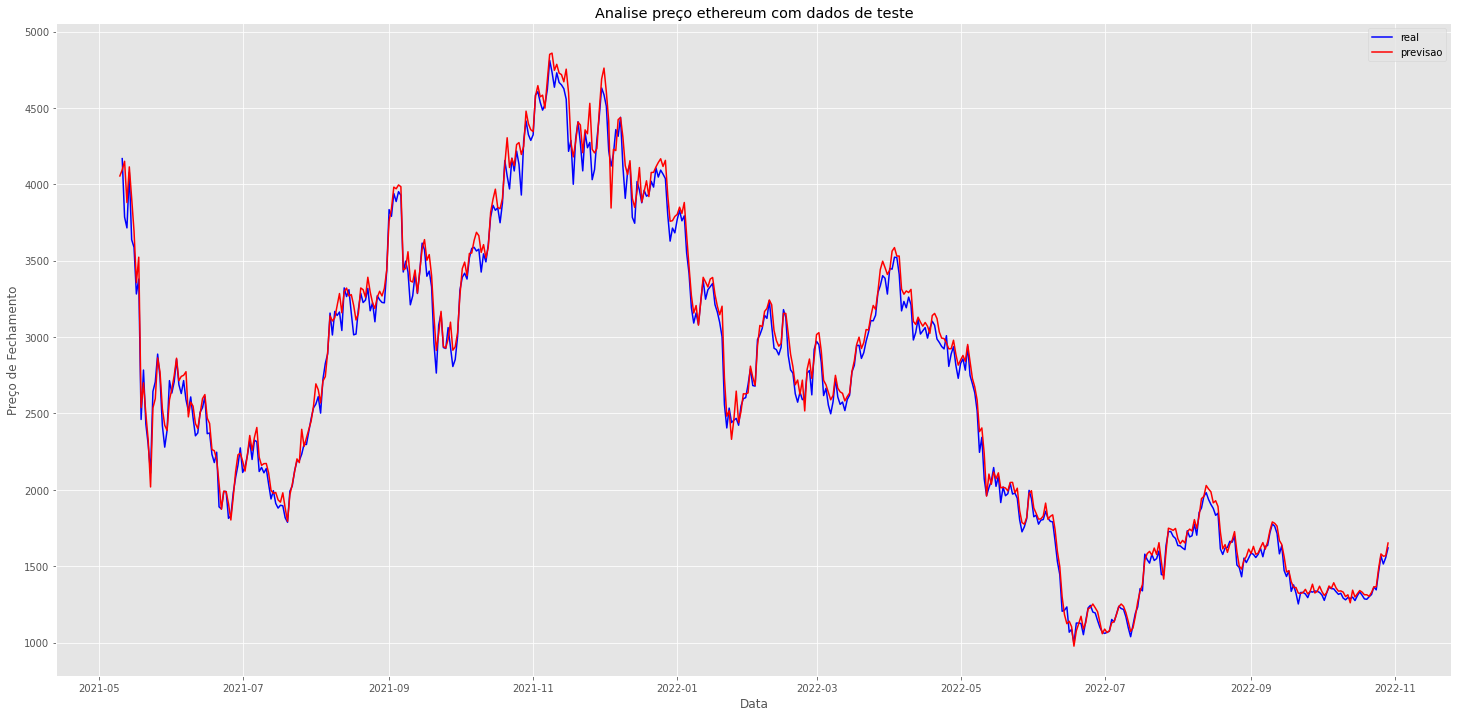

In [30]:
plt.figure(figsize=(25,12))
plt.title("Analise preço ethereum com dados de teste")
plt.plot(df["real"], label="real", color="blue")
plt.plot(df["previsao"], label="previsao", color="red")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
leg = plt.legend()

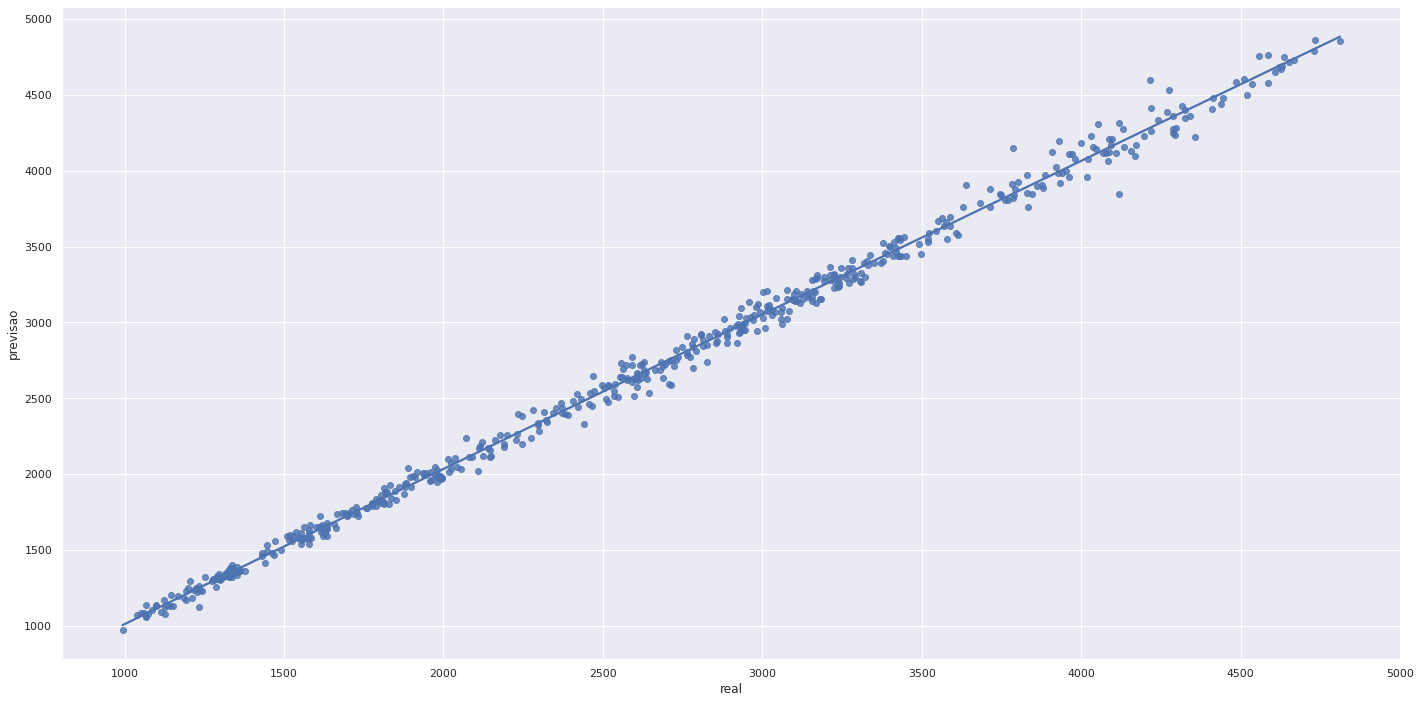

In [31]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(24, 12)})
sns.regplot(x ="real", y ="previsao", data = df, ci=False, order=2)

- Export modelo preditivo 

In [32]:
joblib.dump(pipeline_linear_regression, 'model_eth_usd.pkl')

['model_eth_usd.pkl']

- Import modelo preditivo

In [33]:
model = joblib.load('model_eth_usd.pkl')